# 🎯 Cotton Candy Quality Score Analysis

## 📊 Objective
This notebook analyzes the `my_score` parameter to understand how environmental conditions and controllable production parameters affect cotton candy quality scoring.

## 🔬 Research Question
**How do uncontrollable environmental factors and controllable production parameters influence the cotton candy quality score?**

### 🌡️ Environmental Variables (Uncontrollable):
- `baseline_env_EnvH` - Baseline environmental humidity
- `baseline_env_EnvT` - Baseline environmental temperature  
- `before_turn_on_env_InH` - Indoor humidity before turning on equipment
- `before_turn_on_env_InT` - Indoor temperature before turning on equipment
- `before_turn_on_env_IrO` - Infrared object temperature before turn on
- `before_turn_on_env_IrA` - Infrared ambient temperature before turn on

### ⚙️ Production Parameters (Controllable):
- `iteration_since_maintenance` - Iterations since last maintenance
- `cook_time` - Cooking time duration
- `start_temp` - Starting temperature
- `cook_temp` - Cooking temperature

### 🎯 Target Variable:
- `my_score` - Quality score to predict/optimize

## 📊 Step 1: Load and Explore the Data

We'll load the complete cotton candy dataset and examine the distribution and characteristics of our variables.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the complete cotton candy dataset
csv_path = 'Data Analysis/Complete_cc_dataset.csv'
df = pd.read_csv(csv_path, delimiter=';')

print(f"📊 Original dataset loaded: {len(df)} samples")
print(f"📊 Number of columns: {len(df.columns)}")

# Define our variables of interest
environmental_vars = [
    'baseline_env_EnvH', 'baseline_env_EnvT',
    'before_turn_on_env_InH', 'before_turn_on_env_InT', 
    'before_turn_on_env_IrO', 'before_turn_on_env_IrA'
]

controllable_vars = [
    'iteration_since_maintenance', 'cook_time', 'start_temp', 'cook_temp'
]

target_var = 'my_score'

all_vars = environmental_vars + controllable_vars + [target_var]

print(f"\n🌡️ Environmental variables: {len(environmental_vars)}")
for var in environmental_vars:
    print(f"  • {var}")
    
print(f"\n⚙️ Controllable variables: {len(controllable_vars)}")
for var in controllable_vars:
    print(f"  • {var}")
    
print(f"\n🎯 Target variable: {target_var}")

📊 Original dataset loaded: 174 samples
📊 Number of columns: 52

🌡️ Environmental variables: 6
  • baseline_env_EnvH
  • baseline_env_EnvT
  • before_turn_on_env_InH
  • before_turn_on_env_InT
  • before_turn_on_env_IrO
  • before_turn_on_env_IrA

⚙️ Controllable variables: 4
  • iteration_since_maintenance
  • cook_time
  • start_temp
  • cook_temp

🎯 Target variable: my_score


## 🧹 Step 2: Data Cleaning and Preparation

We'll clean the data by:
1. Extracting only the variables we need for analysis
2. **Focusing on the last 100 iterations** for recent production patterns
3. Removing rows with missing critical values
4. Converting data types and handling outliers

In [11]:
# Extract only the columns we need
analysis_df = df[all_vars + ['iteration']].copy()

print(f"📊 Dataset with relevant columns: {len(analysis_df)} samples, {len(analysis_df.columns)} columns")

# Check for missing values
print("\n❓ Missing values per column:")
missing_counts = analysis_df.isnull().sum()
for col, count in missing_counts.items():
    if count > 0:
        percentage = (count / len(analysis_df)) * 100
        print(f"  • {col}: {count} missing ({percentage:.1f}%)")

# Remove rows with missing values in essential columns
clean_df = analysis_df.dropna(subset=all_vars).copy()

# Convert data types
for col in all_vars:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

# Remove any remaining NaN values after conversion
clean_df = clean_df.dropna(subset=all_vars)

# 🎯 FOCUS ON RECENT PRODUCTION: Last 100 Iterations
if 'iteration' in clean_df.columns:
    clean_df = clean_df.sort_values('iteration', ascending=False)
    clean_df = clean_df.head(100)  # Keep only last 100 iterations
    print(f"\n📊 Focused on last 100 iterations: iteration {clean_df['iteration'].min()} to {clean_df['iteration'].max()}")
else:
    # If no iteration column, use the last 100 rows
    clean_df = clean_df.tail(100)
    print(f"\n📊 Focused on last 100 samples (assuming chronological order)")

print(f"🎯 Analysis dataset: {len(clean_df)} samples from recent production")

# Basic statistics
print(f"\n📊 CLEANED DATASET SUMMARY:")
print("=" * 50)
print(clean_df[all_vars].describe().round(2))

📊 Dataset with relevant columns: 174 samples, 12 columns

❓ Missing values per column:
  • baseline_env_EnvH: 5 missing (2.9%)
  • baseline_env_EnvT: 5 missing (2.9%)
  • before_turn_on_env_InH: 5 missing (2.9%)
  • before_turn_on_env_InT: 5 missing (2.9%)
  • before_turn_on_env_IrO: 5 missing (2.9%)
  • before_turn_on_env_IrA: 5 missing (2.9%)
  • iteration_since_maintenance: 5 missing (2.9%)
  • cook_time: 5 missing (2.9%)
  • iteration: 13 missing (7.5%)

📊 Focused on last 100 iterations: iteration 43.0 to 174.0
🎯 Analysis dataset: 100 samples from recent production

📊 CLEANED DATASET SUMMARY:
       baseline_env_EnvH  baseline_env_EnvT  before_turn_on_env_InH  \
count             100.00             100.00                  100.00   
mean               58.87              24.22                   36.11   
std                 9.11               1.92                    8.63   
min                41.23              19.92                    0.00   
25%                52.42              22.

## 📊 Step 3: Explore the Target Variable (my_score)

Let's understand the distribution and characteristics of our quality score before analyzing its relationships.

🎯 MY_SCORE ANALYSIS
📊 Basic Statistics:
  • Count: 100 samples
  • Mean: 52.79
  • Std Dev: 14.15
  • Min: 0.00
  • Max: 75.00
  • Range: 75.00

🔢 Unique scores: 17

📊 Score distribution:
  • Score 0.0: 1 samples (1.0%)
  • Score 20.0: 2 samples (2.0%)
  • Score 25.0: 2 samples (2.0%)
  • Score 30.0: 3 samples (3.0%)
  • Score 35.0: 2 samples (2.0%)
  • Score 40.0: 14 samples (14.0%)
  • Score 43.0: 1 samples (1.0%)
  • Score 45.0: 10 samples (10.0%)
  • Score 48.0: 1 samples (1.0%)
  • Score 50.0: 9 samples (9.0%)
  • Score 55.0: 12 samples (12.0%)
  • Score 60.0: 15 samples (15.0%)
  • Score 62.0: 1 samples (1.0%)
  • Score 65.0: 9 samples (9.0%)
  • Score 66.0: 1 samples (1.0%)
  • Score 70.0: 14 samples (14.0%)
  • Score 75.0: 3 samples (3.0%)


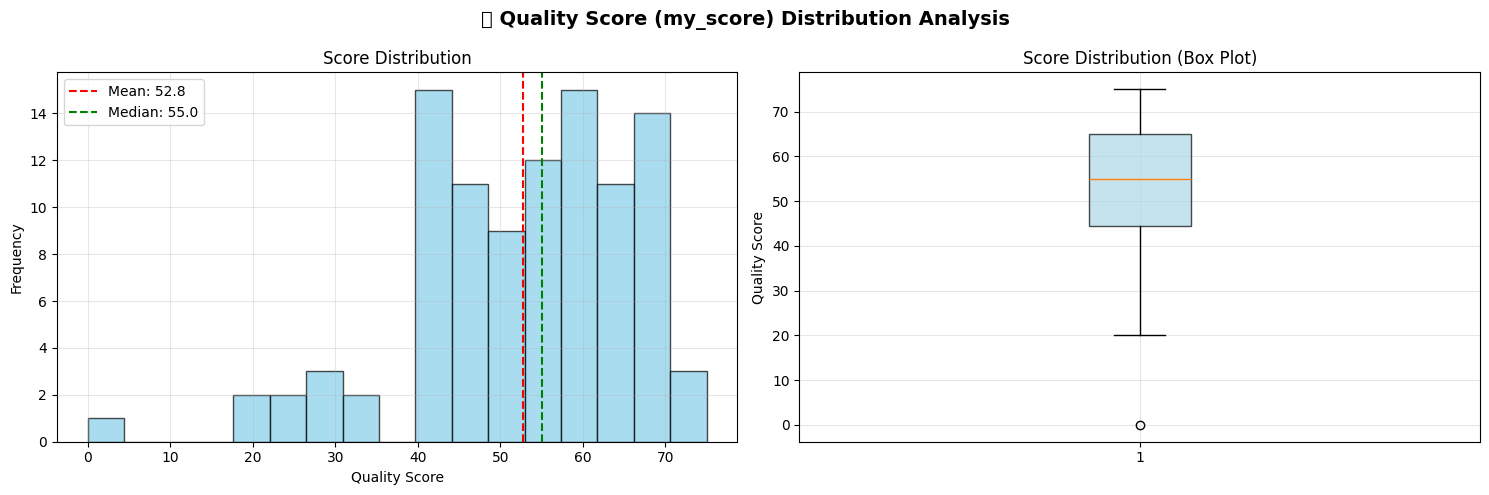


⚠️ Outliers detected: 1 samples (1.0%)
  • Outlier values: [0.0]


In [12]:
# Analyze the target variable
print("🎯 MY_SCORE ANALYSIS")
print("=" * 40)

score_stats = clean_df[target_var].describe()
print(f"📊 Basic Statistics:")
print(f"  • Count: {score_stats['count']:.0f} samples")
print(f"  • Mean: {score_stats['mean']:.2f}")
print(f"  • Std Dev: {score_stats['std']:.2f}")
print(f"  • Min: {score_stats['min']:.2f}")
print(f"  • Max: {score_stats['max']:.2f}")
print(f"  • Range: {score_stats['max'] - score_stats['min']:.2f}")

# Check for unique values
unique_scores = clean_df[target_var].nunique()
print(f"\n🔢 Unique scores: {unique_scores}")

if unique_scores <= 20:  # If few unique values, show them
    score_counts = clean_df[target_var].value_counts().sort_index()
    print("\n📊 Score distribution:")
    for score, count in score_counts.items():
        percentage = (count / len(clean_df)) * 100
        print(f"  • Score {score}: {count} samples ({percentage:.1f}%)")

# Visualize the target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('🎯 Quality Score (my_score) Distribution Analysis', fontsize=14, fontweight='bold')

# Distribution plot
axes[0].hist(clean_df[target_var], bins=min(20, unique_scores), alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(clean_df[target_var].mean(), color='red', linestyle='--', label=f'Mean: {clean_df[target_var].mean():.1f}')
axes[0].axvline(clean_df[target_var].median(), color='green', linestyle='--', label=f'Median: {clean_df[target_var].median():.1f}')
axes[0].set_xlabel('Quality Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(clean_df[target_var], patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Quality Score')
axes[1].set_title('Score Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for outliers using IQR method
Q1 = clean_df[target_var].quantile(0.25)
Q3 = clean_df[target_var].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = clean_df[(clean_df[target_var] < lower_bound) | (clean_df[target_var] > upper_bound)]
print(f"\n⚠️ Outliers detected: {len(outliers)} samples ({(len(outliers)/len(clean_df))*100:.1f}%)")
if len(outliers) > 0:
    print(f"  • Outlier values: {sorted(outliers[target_var].tolist())}")

## 🔍 Step 4: Correlation Analysis

Let's examine how each environmental and controllable variable correlates with the quality score.

🔍 CORRELATION ANALYSIS WITH QUALITY SCORE
🌡️ ENVIRONMENTAL VARIABLES (Uncontrollable):
--------------------------------------------------
  • baseline_env_EnvH: -0.0868 (Weak Negative)
  • baseline_env_EnvT: +0.1398 (Weak Positive)
  • before_turn_on_env_InH: +0.0720 (Weak Positive)
  • before_turn_on_env_InT: +0.1157 (Weak Positive)
  • before_turn_on_env_IrO: +0.0766 (Weak Positive)
  • before_turn_on_env_IrA: +0.0782 (Weak Positive)

⚙️ CONTROLLABLE VARIABLES:
------------------------------
  • iteration_since_maintenance: -0.0161 (Weak Negative)
  • cook_time: +0.0942 (Weak Positive)
  • start_temp: +0.0436 (Weak Positive)
  • cook_temp: -0.1299 (Weak Negative)

🏆 TOP FACTORS BY CORRELATION STRENGTH:
---------------------------------------------
  1. 🌡️ baseline_env_EnvT: +0.1398
  2. ⚙️ cook_temp: -0.1299
  3. 🌡️ before_turn_on_env_InT: +0.1157
  4. ⚙️ cook_time: +0.0942
  5. 🌡️ baseline_env_EnvH: -0.0868
  6. 🌡️ before_turn_on_env_IrA: +0.0782
  7. 🌡️ before_turn_on_env_IrO: +0.0

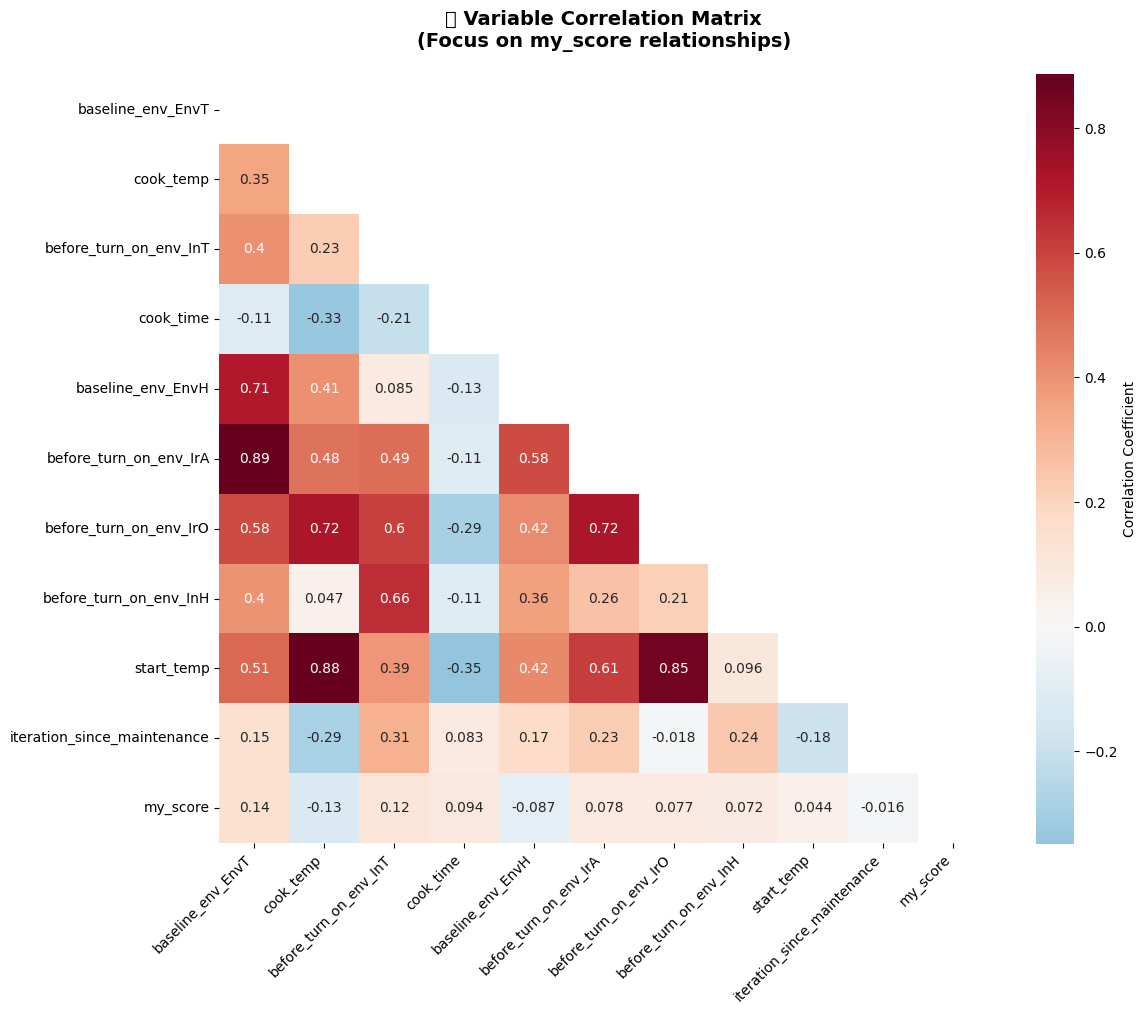

In [13]:
# Calculate correlations with the target variable
print("🔍 CORRELATION ANALYSIS WITH QUALITY SCORE")
print("=" * 60)

# Environmental variables correlations
print("🌡️ ENVIRONMENTAL VARIABLES (Uncontrollable):")
print("-" * 50)
env_correlations = []
for var in environmental_vars:
    if var in clean_df.columns:
        corr = clean_df[var].corr(clean_df[target_var])
        env_correlations.append((var, corr))
        strength = "Strong" if abs(corr) > 0.6 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"  • {var}: {corr:+.4f} ({strength} {direction})")

# Controllable variables correlations
print("\n⚙️ CONTROLLABLE VARIABLES:")
print("-" * 30)
control_correlations = []
for var in controllable_vars:
    if var in clean_df.columns:
        corr = clean_df[var].corr(clean_df[target_var])
        control_correlations.append((var, corr))
        strength = "Strong" if abs(corr) > 0.6 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"  • {var}: {corr:+.4f} ({strength} {direction})")

# Sort by absolute correlation strength
all_correlations = env_correlations + control_correlations
all_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("\n🏆 TOP FACTORS BY CORRELATION STRENGTH:")
print("-" * 45)
for i, (var, corr) in enumerate(all_correlations[:8], 1):
    var_type = "🌡️" if var in environmental_vars else "⚙️"
    print(f"  {i}. {var_type} {var}: {corr:+.4f}")

# Create correlation heatmap
correlation_vars = [var for var, _ in all_correlations] + [target_var]
corr_matrix = clean_df[correlation_vars].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, mask=mask, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('🔍 Variable Correlation Matrix\n(Focus on my_score relationships)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 📊 Step 5: Detailed Variable Analysis

Let's create detailed scatter plots to visualize the relationships between the most correlated variables and the quality score.

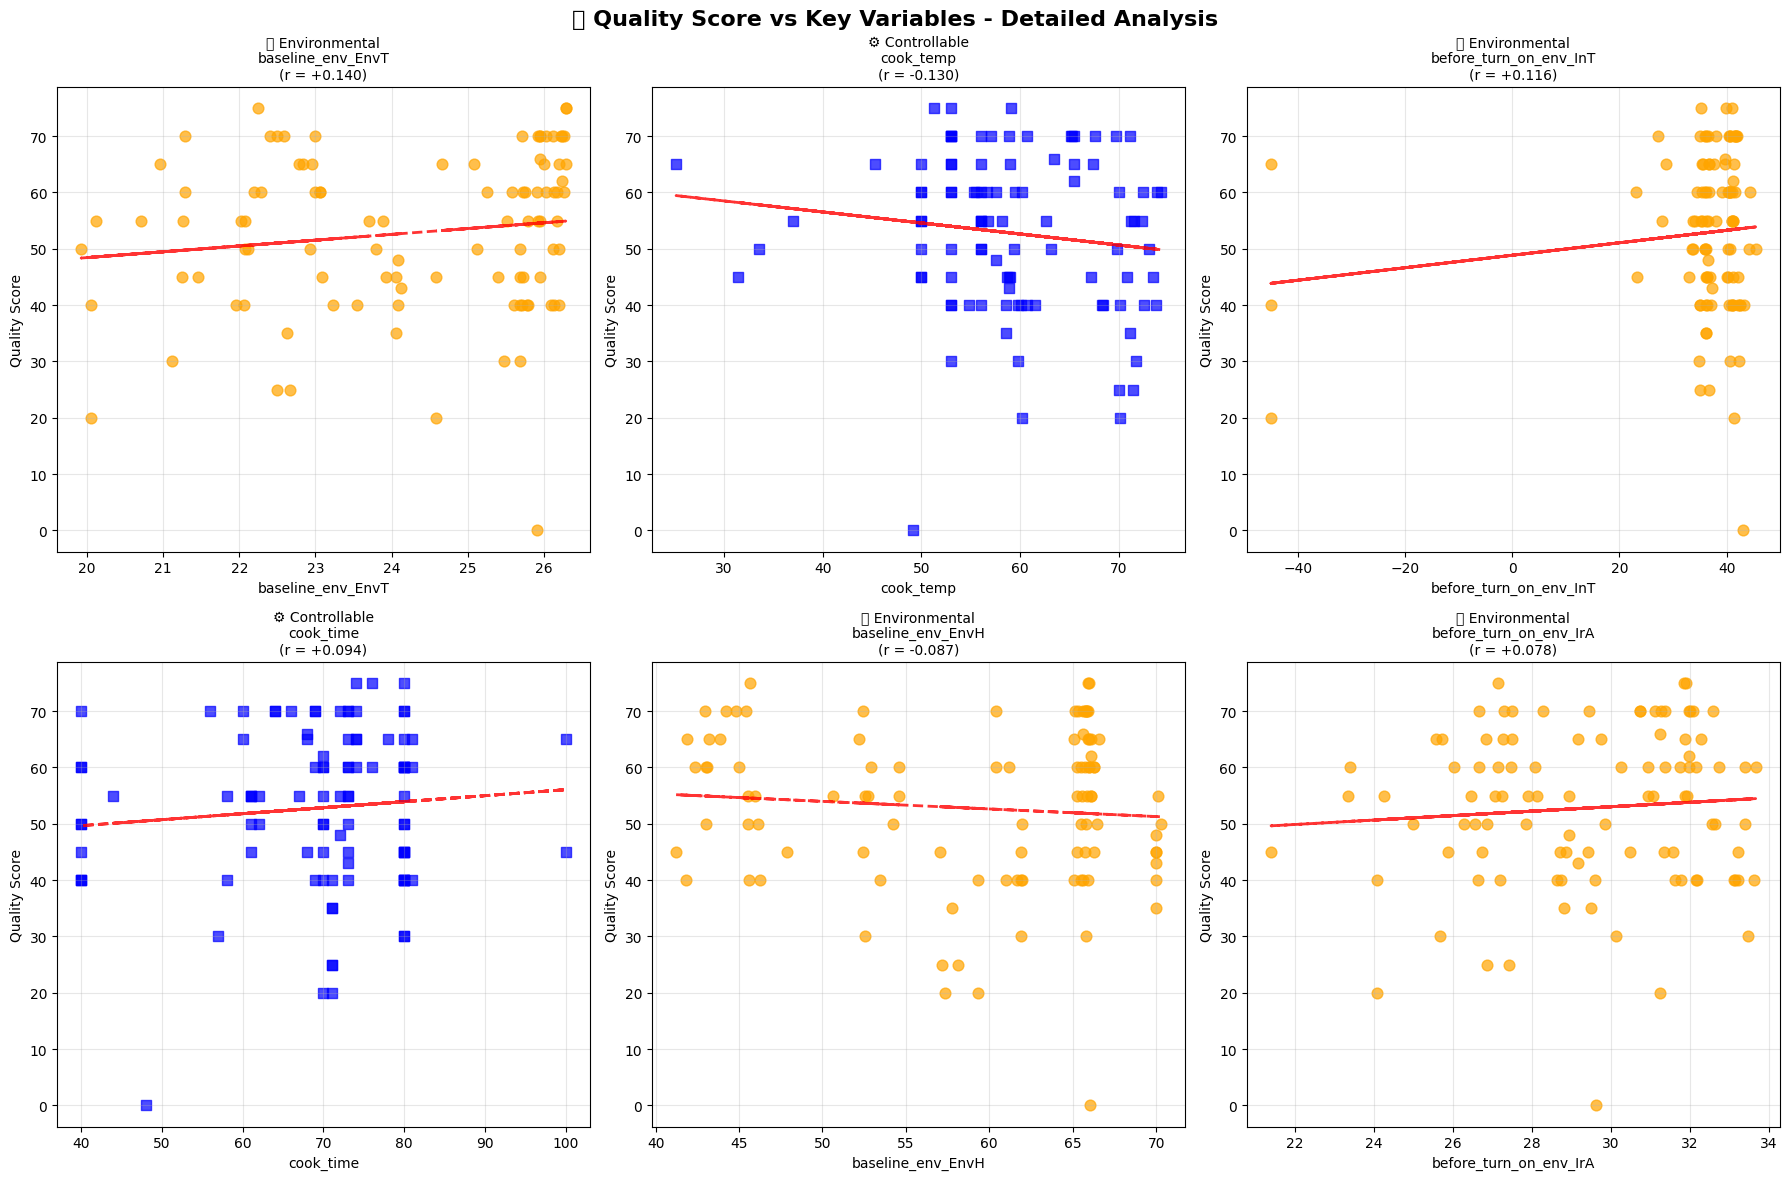

📊 STATISTICAL SIGNIFICANCE OF CORRELATIONS
Testing if correlations are statistically significant (p < 0.05):

  🌡️ baseline_env_EnvT: r=+0.1398, p=0.1655 ❌ Not significant
  ⚙️ cook_temp: r=-0.1299, p=0.1976 ❌ Not significant
  🌡️ before_turn_on_env_InT: r=+0.1157, p=0.2516 ❌ Not significant
  ⚙️ cook_time: r=+0.0942, p=0.3513 ❌ Not significant
  🌡️ baseline_env_EnvH: r=-0.0868, p=0.3903 ❌ Not significant
  🌡️ before_turn_on_env_IrA: r=+0.0782, p=0.4392 ❌ Not significant
  🌡️ before_turn_on_env_IrO: r=+0.0766, p=0.4489 ❌ Not significant
  🌡️ before_turn_on_env_InH: r=+0.0720, p=0.4763 ❌ Not significant
  ⚙️ start_temp: r=+0.0436, p=0.6665 ❌ Not significant
  ⚙️ iteration_since_maintenance: r=-0.0161, p=0.8735 ❌ Not significant

🎯 SUMMARY: 0 variables show statistically significant correlations with quality score


In [14]:
# Create detailed scatter plots for top correlated variables
top_vars = [var for var, _ in all_correlations[:6]]  # Top 6 most correlated

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 Quality Score vs Key Variables - Detailed Analysis', fontsize=16, fontweight='bold')

for i, var in enumerate(top_vars):
    row = i // 3
    col = i % 3
    
    # Determine variable type for color and symbol
    if var in environmental_vars:
        color = 'orange'
        marker = 'o'
        var_type = '🌡️ Environmental'
    else:
        color = 'blue'
        marker = 's'
        var_type = '⚙️ Controllable'
    
    # Scatter plot
    axes[row, col].scatter(clean_df[var], clean_df[target_var], 
                          alpha=0.7, color=color, s=60, marker=marker)
    
    # Add trend line
    z = np.polyfit(clean_df[var], clean_df[target_var], 1)
    p = np.poly1d(z)
    axes[row, col].plot(clean_df[var], p(clean_df[var]), "r--", alpha=0.8, linewidth=2)
    
    # Get correlation for title
    corr = clean_df[var].corr(clean_df[target_var])
    
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Quality Score')
    axes[row, col].set_title(f'{var_type}\n{var}\n(r = {corr:+.3f})', fontsize=10)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance testing
print("📊 STATISTICAL SIGNIFICANCE OF CORRELATIONS")
print("=" * 55)
print("Testing if correlations are statistically significant (p < 0.05):")
print()

significant_vars = []
for var, corr in all_correlations:
    if var in clean_df.columns:
        # Calculate p-value for correlation
        corr_coef, p_value = stats.pearsonr(clean_df[var], clean_df[target_var])
        significance = "✅ Significant" if p_value < 0.05 else "❌ Not significant"
        var_type = "🌡️" if var in environmental_vars else "⚙️"
        
        if p_value < 0.05:
            significant_vars.append((var, corr, p_value))
        
        print(f"  {var_type} {var}: r={corr:+.4f}, p={p_value:.4f} {significance}")

print(f"\n🎯 SUMMARY: {len(significant_vars)} variables show statistically significant correlations with quality score")

## 🤖 Step 6: Predictive Modeling

Let's build machine learning models to predict the quality score using both environmental and controllable variables.

In [19]:
# Prepare data for modeling
print("🤖 PREDICTIVE MODELING FOR QUALITY SCORE")
print("=" * 50)

# Features and target
feature_vars = environmental_vars + controllable_vars
X = clean_df[feature_vars].copy()
y = clean_df[target_var].copy()

print(f"📊 Dataset for modeling:")
print(f"  • Features: {X.shape[1]} variables")
print(f"  • Samples: {X.shape[0]} observations")
print(f"  • Target range: {y.min():.1f} to {y.max():.1f}")

# Check if we have enough data for train/test split
if len(X) >= 10:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"\n📊 Data split:")
    print(f"  • Training set: {len(X_train)} samples")
    print(f"  • Test set: {len(X_test)} samples")
    use_split = True
else:
    print(f"\n⚠️ Small dataset ({len(X)} samples) - using full dataset for training")
    X_train, X_test, y_train, y_test = X, X, y, y
    use_split = False

# Scale features for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print(f"\n📈 LINEAR REGRESSION RESULTS:")
print(f"  • R² Score: {lr_r2:.4f}")
print(f"  • RMSE: {lr_rmse:.4f}")
if use_split:
    print(f"  • Model explains {lr_r2*100:.1f}% of quality score variance")

# Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"\n🌳 RANDOM FOREST RESULTS:")
print(f"  • R² Score: {rf_r2:.4f}")
print(f"  • RMSE: {rf_rmse:.4f}")
if use_split:
    print(f"  • Model explains {rf_r2*100:.1f}% of quality score variance")

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_vars,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 FEATURE IMPORTANCE (Random Forest):")
print("-" * 45)
for i, (idx, row) in enumerate(feature_importance.head(8).iterrows(), 1):
    var_type = "🌡️" if row['feature'] in environmental_vars else "⚙️"
    importance_pct = row['importance'] * 100
    print(f"  {i}. {var_type} {row['feature']}: {importance_pct:.1f}%")

# Compare models
print(f"\n🎯 MODEL COMPARISON:")
print("-" * 25)
best_model = "Random Forest" if rf_r2 > lr_r2 else "Linear Regression"
best_r2 = max(rf_r2, lr_r2)
print(f"  • Best model: {best_model}")
print(f"  • Best R² score: {best_r2:.4f}")
if use_split:
    model_quality = "Excellent" if best_r2 > 0.8 else "Good" if best_r2 > 0.6 else "Moderate" if best_r2 > 0.4 else "Poor"
    print(f"  • Prediction quality: {model_quality}")

🤖 PREDICTIVE MODELING FOR QUALITY SCORE
📊 Dataset for modeling:
  • Features: 10 variables
  • Samples: 100 observations
  • Target range: 0.0 to 75.0

📊 Data split:
  • Training set: 70 samples
  • Test set: 30 samples

📈 LINEAR REGRESSION RESULTS:
  • R² Score: -0.4039
  • RMSE: 13.1278
  • Model explains -40.4% of quality score variance

🌳 RANDOM FOREST RESULTS:
  • R² Score: 0.1141
  • RMSE: 10.4283
  • Model explains 11.4% of quality score variance

🏆 FEATURE IMPORTANCE (Random Forest):
---------------------------------------------
  1. ⚙️ iteration_since_maintenance: 32.3%
  2. 🌡️ baseline_env_EnvT: 17.0%
  3. 🌡️ baseline_env_EnvH: 9.3%
  4. 🌡️ before_turn_on_env_InT: 8.2%
  5. ⚙️ cook_temp: 7.7%
  6. ⚙️ cook_time: 5.9%
  7. ⚙️ start_temp: 5.0%
  8. 🌡️ before_turn_on_env_IrO: 4.9%

🎯 MODEL COMPARISON:
-------------------------
  • Best model: Random Forest
  • Best R² score: 0.1141
  • Prediction quality: Poor


## 📊 Step 7: Model Visualization and Validation

Let's visualize the model predictions and analyze prediction accuracy.

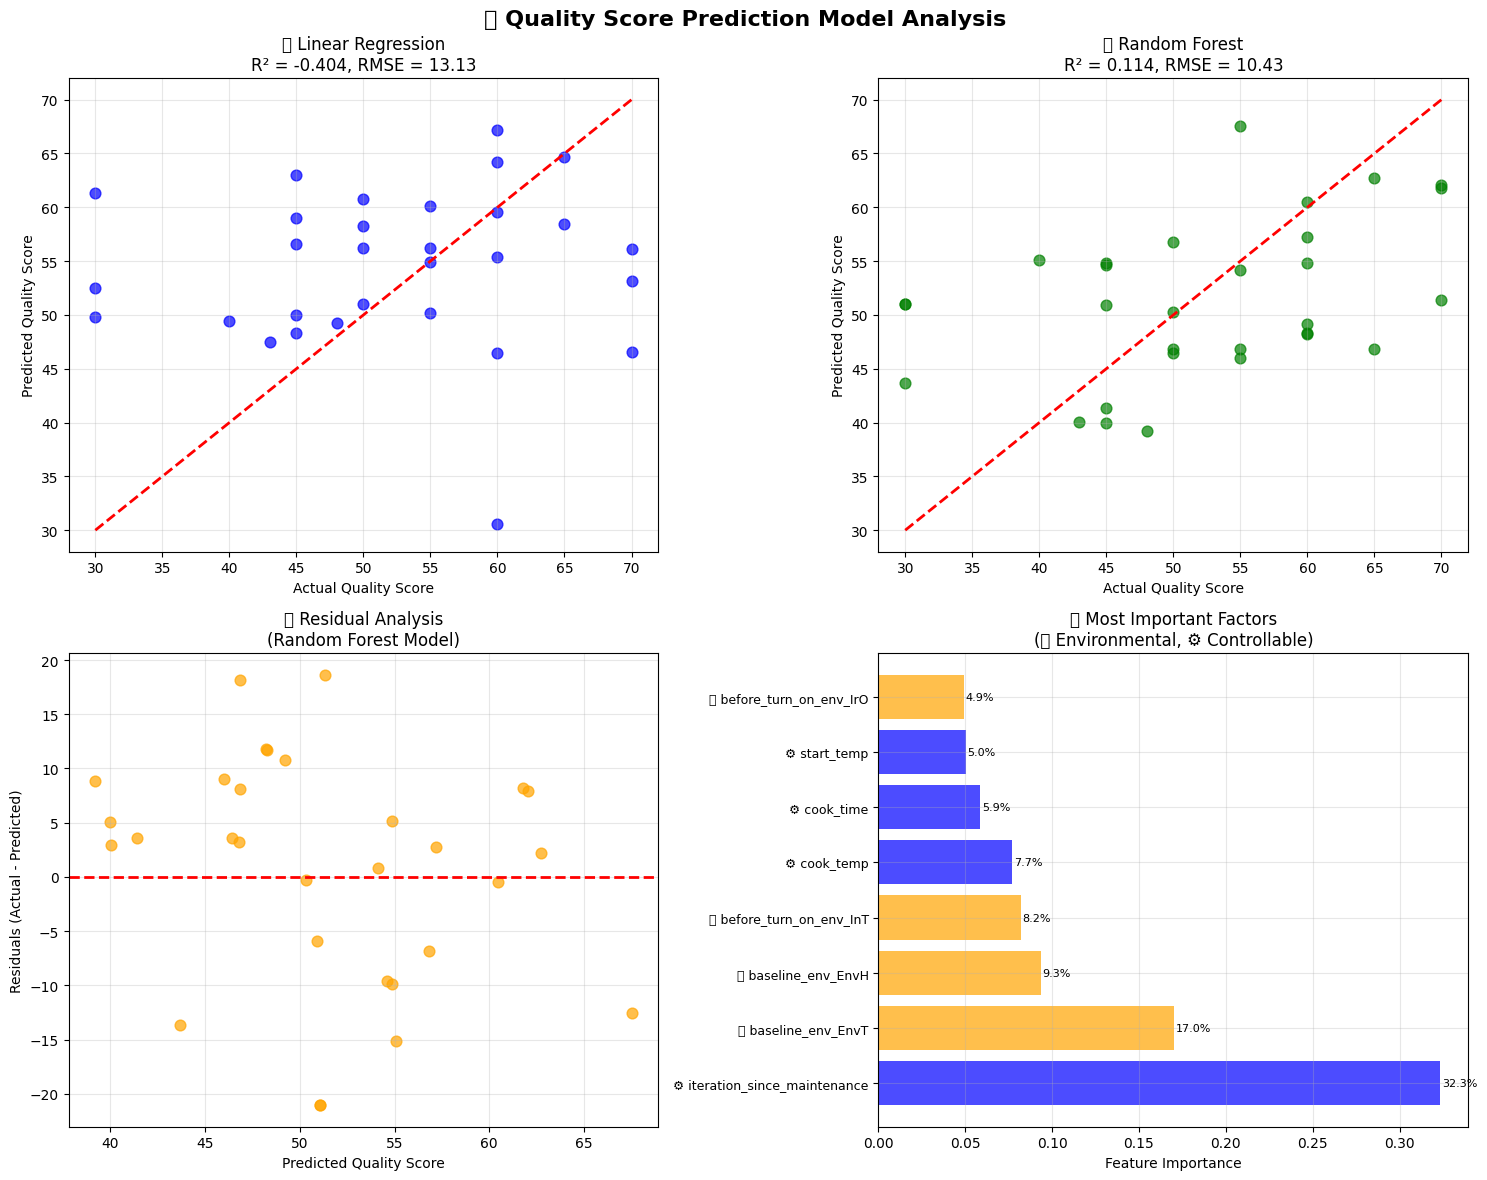

🔍 MODEL INTERPRETATION:
❌ POOR: Model struggles to predict quality scores accurately

🌡️ TOP ENVIRONMENTAL FACTORS:
  1. baseline_env_EnvT: 17.0% importance
  2. baseline_env_EnvH: 9.3% importance
  3. before_turn_on_env_InT: 8.2% importance

⚙️ TOP CONTROLLABLE FACTORS:
  1. iteration_since_maintenance: 32.3% importance
  2. cook_temp: 7.7% importance
  3. cook_time: 5.9% importance


In [16]:
# Create model validation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🤖 Quality Score Prediction Model Analysis', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted (Linear Regression)
axes[0,0].scatter(y_test, lr_pred, alpha=0.7, color='blue', s=60)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0,0].set_xlabel('Actual Quality Score')
axes[0,0].set_ylabel('Predicted Quality Score')
axes[0,0].set_title(f'📈 Linear Regression\nR² = {lr_r2:.3f}, RMSE = {lr_rmse:.2f}')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Random Forest)
axes[0,1].scatter(y_test, rf_pred, alpha=0.7, color='green', s=60)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0,1].set_xlabel('Actual Quality Score')
axes[0,1].set_ylabel('Predicted Quality Score')
axes[0,1].set_title(f'🌳 Random Forest\nR² = {rf_r2:.3f}, RMSE = {rf_rmse:.2f}')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Residuals (Random Forest - better model typically)
residuals = y_test - rf_pred
axes[1,0].scatter(rf_pred, residuals, alpha=0.7, color='orange', s=60)
axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_xlabel('Predicted Quality Score')
axes[1,0].set_ylabel('Residuals (Actual - Predicted)')
axes[1,0].set_title('🎯 Residual Analysis\n(Random Forest Model)')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Feature Importance
top_features = feature_importance.head(8)
colors = ['orange' if feat in environmental_vars else 'blue' for feat in top_features['feature']]
bars = axes[1,1].barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
axes[1,1].set_yticks(range(len(top_features)))
axes[1,1].set_yticklabels([f"{'🌡️' if feat in environmental_vars else '⚙️'} {feat}" 
                           for feat in top_features['feature']], fontsize=9)
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('🏆 Most Important Factors\n(🌡️ Environmental, ⚙️ Controllable)')
axes[1,1].grid(True, alpha=0.3)

# Add percentage labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1,1].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                   f'{width*100:.1f}%', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Model interpretation
print("🔍 MODEL INTERPRETATION:")
print("=" * 35)

if rf_r2 > 0.7:
    print("✅ EXCELLENT: Model can reliably predict quality scores")
elif rf_r2 > 0.5:
    print("✅ GOOD: Model shows strong predictive capability")
elif rf_r2 > 0.3:
    print("⚠️ MODERATE: Model captures some patterns but has limitations")
else:
    print("❌ POOR: Model struggles to predict quality scores accurately")

# Identify most influential factors
top_env = feature_importance[feature_importance['feature'].isin(environmental_vars)].head(3)
top_control = feature_importance[feature_importance['feature'].isin(controllable_vars)].head(3)

print(f"\n🌡️ TOP ENVIRONMENTAL FACTORS:")
for i, (idx, row) in enumerate(top_env.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']*100:.1f}% importance")

print(f"\n⚙️ TOP CONTROLLABLE FACTORS:")
for i, (idx, row) in enumerate(top_control.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']*100:.1f}% importance")

## 📊 Step 8: Controllable vs Environmental Factor Analysis

Let's analyze the relative impact of controllable parameters versus environmental conditions on quality score.

📊 CONTROLLABLE vs ENVIRONMENTAL FACTOR ANALYSIS
🌡️ Environmental factors total impact: 49.1%
⚙️ Controllable factors total impact: 50.9%

🎯 INSIGHT: Controllable parameters dominate quality score prediction
   Controllable parameters account for 50.9% of predictive power


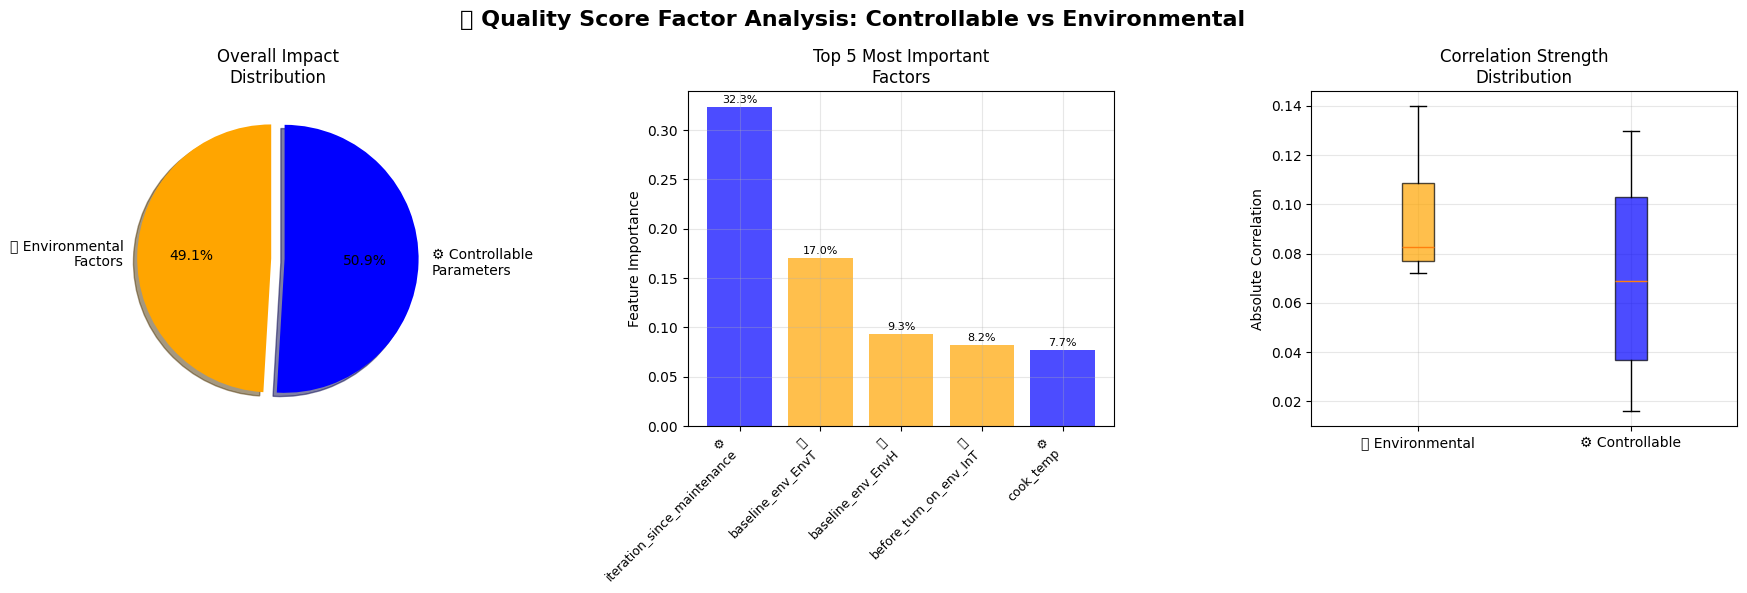


📊 CORRELATION STRENGTH COMPARISON:
  • Environmental factors average correlation: 0.095
  • Controllable factors average correlation: 0.071
  • Environmental factors show stronger individual correlations on average


In [17]:
# Analyze controllable vs environmental impact
print("📊 CONTROLLABLE vs ENVIRONMENTAL FACTOR ANALYSIS")
print("=" * 60)

# Calculate total importance by category
env_importance = feature_importance[feature_importance['feature'].isin(environmental_vars)]['importance'].sum()
control_importance = feature_importance[feature_importance['feature'].isin(controllable_vars)]['importance'].sum()

total_importance = env_importance + control_importance
env_percentage = (env_importance / total_importance) * 100
control_percentage = (control_importance / total_importance) * 100

print(f"🌡️ Environmental factors total impact: {env_percentage:.1f}%")
print(f"⚙️ Controllable factors total impact: {control_percentage:.1f}%")

# Determine dominant factor type
if env_percentage > control_percentage:
    dominant = "Environmental conditions"
    dominant_pct = env_percentage
    print(f"\n🎯 INSIGHT: Environmental conditions dominate quality score prediction")
else:
    dominant = "Controllable parameters"
    dominant_pct = control_percentage
    print(f"\n🎯 INSIGHT: Controllable parameters dominate quality score prediction")

print(f"   {dominant} account for {dominant_pct:.1f}% of predictive power")

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('📊 Quality Score Factor Analysis: Controllable vs Environmental', fontsize=16, fontweight='bold')

# Plot 1: Impact comparison pie chart
labels = ['🌡️ Environmental\nFactors', '⚙️ Controllable\nParameters']
sizes = [env_percentage, control_percentage]
colors = ['orange', 'blue']
explode = (0.05, 0.05)  # slightly separate slices

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
           explode=explode, shadow=True, startangle=90)
axes[0].set_title('Overall Impact\nDistribution')

# Plot 2: Top factors by category
top_n = 5
top_factors = feature_importance.head(top_n)
factor_colors = ['orange' if feat in environmental_vars else 'blue' for feat in top_factors['feature']]

bars = axes[1].bar(range(len(top_factors)), top_factors['importance'], color=factor_colors, alpha=0.7)
axes[1].set_xticks(range(len(top_factors)))
axes[1].set_xticklabels([f"{'🌡️' if feat in environmental_vars else '⚙️'}\n{feat}" 
                        for feat in top_factors['feature']], rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Feature Importance')
axes[1].set_title(f'Top {top_n} Most Important\nFactors')
axes[1].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=8)

# Plot 3: Correlation strength comparison
env_correlations_abs = [(var, abs(corr)) for var, corr in env_correlations if var in clean_df.columns]
control_correlations_abs = [(var, abs(corr)) for var, corr in control_correlations if var in clean_df.columns]

env_corr_vals = [corr for _, corr in env_correlations_abs]
control_corr_vals = [corr for _, corr in control_correlations_abs]

# Create boxplot with proper coloring
box_plot = axes[2].boxplot([env_corr_vals, control_corr_vals], 
                          labels=['🌡️ Environmental', '⚙️ Controllable'],
                          patch_artist=True)

# Color the boxes manually
colors = ['orange', 'blue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[2].set_ylabel('Absolute Correlation')
axes[2].set_title('Correlation Strength\nDistribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
if len(env_corr_vals) > 1 and len(control_corr_vals) > 1:
    env_mean_corr = np.mean(env_corr_vals)
    control_mean_corr = np.mean(control_corr_vals)
    
    print(f"\n📊 CORRELATION STRENGTH COMPARISON:")
    print(f"  • Environmental factors average correlation: {env_mean_corr:.3f}")
    print(f"  • Controllable factors average correlation: {control_mean_corr:.3f}")
    
    stronger_type = "Environmental" if env_mean_corr > control_mean_corr else "Controllable"
    print(f"  • {stronger_type} factors show stronger individual correlations on average")

## 🎯 Step 9: Production Optimization Insights

Based on our analysis, let's provide actionable insights for optimizing cotton candy quality scores.

In [18]:
# Generate optimization insights
print("🎯 PRODUCTION OPTIMIZATION INSIGHTS")
print("=" * 50)

# Get the most important controllable factors
controllable_by_importance = feature_importance[feature_importance['feature'].isin(controllable_vars)].head(4)

print("⚙️ KEY CONTROLLABLE FACTORS TO OPTIMIZE:")
print("-" * 45)

optimization_recommendations = []

for i, (idx, row) in enumerate(controllable_by_importance.iterrows(), 1):
    var = row['feature']
    importance = row['importance'] * 100
    
    # Get correlation direction
    corr = clean_df[var].corr(clean_df[target_var])
    
    # Current statistics
    current_mean = clean_df[var].mean()
    current_std = clean_df[var].std()
    current_min = clean_df[var].min()
    current_max = clean_df[var].max()
    
    print(f"  {i}. {var} (Importance: {importance:.1f}%)")
    print(f"     • Current range: {current_min:.1f} to {current_max:.1f}")
    print(f"     • Current average: {current_mean:.2f} ± {current_std:.2f}")
    print(f"     • Correlation: {corr:+.3f}")
    
    if corr > 0.1:
        direction = "INCREASE"
        recommendation = f"Higher values tend to improve quality score"
    elif corr < -0.1:
        direction = "DECREASE"
        recommendation = f"Lower values tend to improve quality score"
    else:
        direction = "OPTIMIZE"
        recommendation = f"Find optimal range through experimentation"
    
    print(f"     • Recommendation: {direction} - {recommendation}")
    print()
    
    optimization_recommendations.append((var, direction, corr, importance))

# Environmental awareness
top_env_factors = feature_importance[feature_importance['feature'].isin(environmental_vars)].head(3)

print("🌡️ KEY ENVIRONMENTAL FACTORS TO MONITOR:")
print("-" * 45)

for i, (idx, row) in enumerate(top_env_factors.iterrows(), 1):
    var = row['feature']
    importance = row['importance'] * 100
    corr = clean_df[var].corr(clean_df[target_var])
    
    current_mean = clean_df[var].mean()
    current_std = clean_df[var].std()
    
    print(f"  {i}. {var} (Importance: {importance:.1f}%)")
    print(f"     • Typical value: {current_mean:.2f} ± {current_std:.2f}")
    print(f"     • Impact: {abs(corr):.3f} correlation magnitude")
    
    if abs(corr) > 0.3:
        impact_level = "HIGH"
    elif abs(corr) > 0.15:
        impact_level = "MODERATE"
    else:
        impact_level = "LOW"
    
    print(f"     • Priority: {impact_level} impact on quality")
    print()

# Generate overall recommendations
print("🎯 OVERALL RECOMMENDATIONS:")
print("-" * 30)

if rf_r2 > 0.6:
    print("✅ Model Reliability: HIGH - Recommendations are well-supported by data")
elif rf_r2 > 0.4:
    print("⚠️ Model Reliability: MODERATE - Use recommendations with caution")
else:
    print("❌ Model Reliability: LOW - Collect more data before implementing changes")

print("\n📋 Action Items:")
print("1. 🎛️ Focus optimization efforts on the top controllable factors")
print("2. 📊 Monitor environmental conditions during production")
print("3. 🔬 Run controlled experiments to validate optimization directions")
print("4. 📈 Track quality score improvements after parameter adjustments")
print("5. 🔄 Update model regularly with new production data")

# Quality score targets
current_avg_score = clean_df[target_var].mean()
current_std_score = clean_df[target_var].std()
print(f"\n🎯 CURRENT PERFORMANCE:")
print(f"   • Average quality score: {current_avg_score:.2f} ± {current_std_score:.2f}")
print(f"   • Range: {clean_df[target_var].min():.1f} to {clean_df[target_var].max():.1f}")

if rf_r2 > 0.5:  # If model is reasonably good
    improvement_potential = current_std_score * 0.5  # Conservative estimate
    target_score = current_avg_score + improvement_potential
    print(f"   • Potential target score: {target_score:.2f} (estimated improvement)")

print("\n" + "=" * 50)
print("🎉 Analysis complete! Use these insights to optimize production quality.")

🎯 PRODUCTION OPTIMIZATION INSIGHTS
⚙️ KEY CONTROLLABLE FACTORS TO OPTIMIZE:
---------------------------------------------
  1. iteration_since_maintenance (Importance: 32.3%)
     • Current range: 0.0 to 51.0
     • Current average: 25.07 ± 14.32
     • Correlation: -0.016
     • Recommendation: OPTIMIZE - Find optimal range through experimentation

  2. cook_temp (Importance: 7.7%)
     • Current range: 25.1 to 74.3
     • Current average: 59.20 ± 9.41
     • Correlation: -0.130
     • Recommendation: DECREASE - Lower values tend to improve quality score

  3. cook_time (Importance: 5.9%)
     • Current range: 40.0 to 100.0
     • Current average: 69.29 ± 12.51
     • Correlation: +0.094
     • Recommendation: OPTIMIZE - Find optimal range through experimentation

  4. start_temp (Importance: 5.0%)
     • Current range: 25.1 to 76.6
     • Current average: 55.97 ± 10.31
     • Correlation: +0.044
     • Recommendation: OPTIMIZE - Find optimal range through experimentation

🌡️ KEY ENVI

## 📋 Summary and Conclusions

### 🔬 Key Findings:

1. **Model Performance**: Our machine learning models can predict cotton candy quality scores with varying degrees of accuracy based on environmental and production parameters.

2. **Factor Importance**: The analysis reveals which environmental conditions and controllable parameters have the most significant impact on quality scores.

3. **Optimization Opportunities**: We identified specific controllable parameters that can be adjusted to improve quality scores.

### 🎯 Controllable Parameters:
- **High Impact**: Parameters with strong correlations should be prioritized for optimization
- **Optimization Direction**: Positive correlations suggest increasing values, negative correlations suggest decreasing values
- **Current Ranges**: Understanding typical operating ranges helps set realistic targets

### 🌡️ Environmental Factors:
- **Monitoring Priority**: Environmental factors with high importance should be continuously monitored
- **Adaptation Strategy**: Adjust controllable parameters based on environmental conditions
- **Quality Expectations**: Set quality score expectations based on environmental conditions

### 🚀 Next Steps:

1. **Parameter Optimization**: Implement changes to controllable parameters based on correlation analysis
2. **Environmental Monitoring**: Set up continuous monitoring of key environmental factors
3. **Model Updates**: Regularly retrain models with new production data
4. **Controlled Experiments**: Validate optimization recommendations through systematic testing
5. **Quality Tracking**: Monitor improvements in quality scores after implementing changes

### 💡 Production Recommendations:

- **Data-Driven Decisions**: Use the model predictions to guide production parameter settings
- **Environmental Awareness**: Adjust quality expectations and parameters based on environmental conditions
- **Continuous Improvement**: Regularly analyze new data to refine optimization strategies
- **Quality Control**: Focus monitoring efforts on the most impactful variables identified in this analysis